https://bit.ly/RSML-4-hybrid

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162991 sha256=cd3bcdec955c1e2aa562597bd178ab5ee1f4ee4617a6332975b1b0c194bbaf47
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

import pandas as pd
import numpy as np

In [ ]:
!wget 'https://drive.google.com/uc?id=1m0rwReR09achL0xTM6QPoN4tykz5bOMx' -O MovieLens.zip

--2024-04-12 16:12:23--  https://drive.google.com/uc?id=1m0rwReR09achL0xTM6QPoN4tykz5bOMx
Resolving drive.google.com (drive.google.com)... 172.253.63.113, 172.253.63.101, 172.253.63.139, ...
Connecting to drive.google.com (drive.google.com)|172.253.63.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1m0rwReR09achL0xTM6QPoN4tykz5bOMx [following]
--2024-04-12 16:12:23--  https://drive.usercontent.google.com/download?id=1m0rwReR09achL0xTM6QPoN4tykz5bOMx
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.163.132, 2607:f8b0:4004:c1b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.163.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 847695 (828K) [application/octet-stream]
Saving to: ‘MovieLens.zip’

MovieLens.zip       100%[===================>] 827.83K  --.-KB/s    in 0.03s   

2024-04-12 16:12:25 (26.3 MB/s)

In [ ]:
!unzip MovieLens.zip

Archive:  MovieLens.zip
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: tags.csv                


In [ ]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [ ]:
movies_with_ratings = movies.merge(ratings, on='movieId').reset_index(drop=True)
movies_with_ratings.dropna(inplace=True)
movies_with_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


### Первый алгоритм

In [ ]:
dataset = pd.DataFrame({
    'uid': movies_with_ratings.userId,
    'iid': movies_with_ratings.title,
    'rating': movies_with_ratings.rating
})

In [ ]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(dataset, reader)

In [ ]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=1)

In [ ]:
dataset

,uid,iid,rating
0,1,Toy Story (1995),4.0
1,5,Toy Story (1995),4.0
2,7,Toy Story (1995),4.5
3,15,Toy Story (1995),2.5
4,17,Toy Story (1995),4.5
...,...,...,...
100831,184,Black Butler: Book of the Atlantic (2017),4.0
100832,184,No Game No Life: Zero (2017),3.5
100833,184,Flint (2017),3.5
100834,184,Bungo Stray Dogs: Dead Apple (2018),3.5


In [ ]:
%%time
algo = SVD(n_factors=20, n_epochs=20, random_state=1)
algo.fit(trainset)

CPU times: user 793 ms, sys: 0 ns, total: 793 ms
Wall time: 797 ms


In [ ]:
test_pred = algo.test(testset)
accuracy.rmse(test_pred, verbose=True)

RMSE: 0.8692


0.8691869654536316

In [ ]:
algo.predict(uid=2.0, iid='Mortal Kombat (1995')

Prediction(uid=2.0, iid='Mortal Kombat (1995', r_ui=None, est=3.5677930762567778, details={'was_impossible': False})

In [ ]:
current_user_id = 2.0
user_movies = movies_with_ratings[movies_with_ratings.userId == current_user_id].title.unique()

scores = []
titles = []

for movie in movies_with_ratings.title.unique():
    if movie in user_movies:
        continue

    scores.append(algo.predict(uid=current_user_id, iid=movie).est)
    titles.append(movie)

In [ ]:
best_indices = np.argsort(scores)[-10:]
for i in reversed(best_indices):
    print(titles[i], scores[i])

Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) 4.458356255708089
Lawrence of Arabia (1962) 4.446104769972092
Forrest Gump (1994) 4.42636668084545
Star Wars: Episode IV - A New Hope (1977) 4.401676774438217
Blade Runner (1982) 4.39154977497449
Ghost in the Shell (Kôkaku kidôtai) (1995) 4.388125374548114
Godfather: Part II, The (1974) 4.378709724809865
Army of Darkness (1993) 4.370871473380388
Cool Hand Luke (1967) 4.365541501119044
Schindler's List (1993) 4.364891629483209


### Второй алгоритм

In [ ]:
def change_string(s):
    return s.replace(' ', '').replace('-', '')

movie_genres = [change_string(g) for g in movies.genres.values]
movie_genres[:10]

['Adventure|Animation|Children|Comedy|Fantasy',
 'Adventure|Children|Fantasy',
 'Comedy|Romance',
 'Comedy|Drama|Romance',
 'Comedy',
 'Action|Crime|Thriller',
 'Comedy|Romance',
 'Adventure|Children',
 'Action',
 'Action|Adventure|Thriller']

In [ ]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(movie_genres)
X_train_tfidf

<9742x20 sparse matrix of type '<class 'numpy.float64'>'
	with 22084 stored elements in Compressed Sparse Row format>

In [ ]:
neigh = NearestNeighbors(n_neighbors=20, metric='euclidean')
neigh.fit(X_train_tfidf)

NearestNeighbors(metric='euclidean', n_neighbors=20)

In [ ]:
test = change_string("Adventure|Comedy|Fantasy|Crime")

X_tfidf = tfidf.transform([test])

res = neigh.kneighbors(X_tfidf, return_distance=True)

In [ ]:
X_tfidf

<1x20 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [ ]:
res

(array([[0.42079615, 0.53300564, 0.54288608, 0.54288608, 0.54288608,
         0.54288608, 0.54288608, 0.54288608, 0.54288608, 0.54288608,
         0.54288608, 0.54288608, 0.54288608, 0.54288608, 0.54288608,
         0.54288608, 0.54288608, 0.6188388 , 0.62682864, 0.62682864]]),
 array([[6774, 9096, 2302, 5627, 6723, 8361, 5737, 2608, 7865, 5636, 3302,
         7496, 3582,  863, 3376, 9717, 3576, 2206, 3010, 6133]]))

In [ ]:
movies.iloc[res[1][0]]

,movieId,title,genres
6774,60074,Hancock (2008),Action|Adventure|Comedy|Crime|Fantasy
9096,143559,L.A. Slasher (2015),Comedy|Crime|Fantasy
2302,3052,Dogma (1999),Adventure|Comedy|Fantasy
5627,27251,"10th Kingdom, The (2000)",Adventure|Comedy|Fantasy
6723,58972,Nim's Island (2008),Adventure|Comedy|Fantasy
8361,109042,Knights of Badassdom (2013),Adventure|Comedy|Fantasy
5737,30810,"Life Aquatic with Steve Zissou, The (2004)",Adventure|Comedy|Fantasy
2608,3489,Hook (1991),Adventure|Comedy|Fantasy
7865,94015,Mirror Mirror (2012),Adventure|Comedy|Fantasy
5636,27368,Asterix & Obelix: Mission Cleopatra (Astérix &...,Adventure|Comedy|Fantasy


In [ ]:
title_genres = {}

for index, row in tqdm(movies.iterrows()):
    title_genres[row.title] = row.genres

title_genres

0it [00:00, ?it/s]

{'Toy Story (1995)': 'Adventure|Animation|Children|Comedy|Fantasy',
 'Jumanji (1995)': 'Adventure|Children|Fantasy',
 'Grumpier Old Men (1995)': 'Comedy|Romance',
 'Waiting to Exhale (1995)': 'Comedy|Drama|Romance',
 'Father of the Bride Part II (1995)': 'Comedy',
 'Heat (1995)': 'Action|Crime|Thriller',
 'Sabrina (1995)': 'Comedy|Romance',
 'Tom and Huck (1995)': 'Adventure|Children',
 'Sudden Death (1995)': 'Action',
 'GoldenEye (1995)': 'Action|Adventure|Thriller',
 'American President, The (1995)': 'Comedy|Drama|Romance',
 'Dracula: Dead and Loving It (1995)': 'Comedy|Horror',
 'Balto (1995)': 'Adventure|Animation|Children',
 'Nixon (1995)': 'Drama',
 'Cutthroat Island (1995)': 'Action|Adventure|Romance',
 'Casino (1995)': 'Crime|Drama',
 'Sense and Sensibility (1995)': 'Drama|Romance',
 'Four Rooms (1995)': 'Comedy',
 'Ace Ventura: When Nature Calls (1995)': 'Comedy',
 'Money Train (1995)': 'Action|Comedy|Crime|Drama|Thriller',
 'Get Shorty (1995)': 'Comedy|Crime|Thriller',
 'Copy

### Соединяем вместе

In [ ]:
movies_with_ratings[movies_with_ratings.userId == 2].sort_values('timestamp').title.values

array(['Shawshank Redemption, The (1994)', 'Inception (2010)',
       'The Jinx: The Life and Deaths of Robert Durst (2015)',
       'Ex Machina (2015)', 'Django Unchained (2012)', 'Whiplash (2014)',
       'Gladiator (2000)', 'Dark Knight Rises, The (2012)',
       'Shutter Island (2010)', 'Girl with the Dragon Tattoo, The (2011)',
       'Exit Through the Gift Shop (2010)', 'Kill Bill: Vol. 1 (2003)',
       'Collateral (2004)', 'Wolf of Wall Street, The (2013)',
       'Zombieland (2009)', 'Step Brothers (2008)',
       'Talladega Nights: The Ballad of Ricky Bobby (2006)',
       'Tommy Boy (1995)', 'Departed, The (2006)',
       'Dark Knight, The (2008)', 'Interstellar (2014)',
       'Inglourious Basterds (2009)', 'Louis C.K.: Hilarious (2010)',
       'Inside Job (2010)', 'Warrior (2011)', 'Good Will Hunting (1997)',
       'Mad Max: Fury Road (2015)', 'The Drop (2014)', 'Town, The (2010)'],
      dtype=object)

In [ ]:
res[1][0]

array([6774, 9096, 2302, 5627, 6723, 8361, 5737, 2608, 7865, 5636, 3302,
       7496, 3582,  863, 3376, 9717, 3576, 2206, 3010, 6133])

In [ ]:
movies[movies['title'] == 'Town, The (2010)'].movieId.iloc[0]

80489

In [ ]:
def recommend_for_user(user_id):
    user_movies = movies_with_ratings[movies_with_ratings.userId == user_id].sort_values('timestamp').title.values

    # первый
    last_user_movie = user_movies[-1]

    movie_genres = change_string(title_genres[last_user_movie])

    predict = tfidf.transform([movie_genres])
    res = neigh.kneighbors(X_tfidf, return_distance=True)

    movies_to_score = movies.loc[res[1][0]].title.values[1:]

    # второй
    scores = []
    titles = []

    for movie in movies_to_score:
        if movie in user_movies:
            continue

        scores.append(algo.predict(uid=user_id, iid=movie).est)
        titles.append(movie)

    best_indices = np.argsort(scores)[-10:]
    for i in reversed(best_indices):
        print(titles[i], scores[i])

In [ ]:
movies_with_ratings[movies_with_ratings.userId == 2.0].sort_values('rating').tail()

,movieId,title,genres,userId,rating,timestamp
91873,80906,Inside Job (2010),Documentary,2,5.0,1445715172
87775,60756,Step Brothers (2008),Comedy,2,5.0,1445714980
93494,89774,Warrior (2011),Drama,2,5.0,1445715189
96369,106782,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama,2,5.0,1445714966
98703,131724,The Jinx: The Life and Deaths of Robert Durst ...,Documentary,2,5.0,1445714851


In [ ]:
recommend_for_user(2)

Monty Python and the Holy Grail (1975) 4.287134734256706
Adventures of Baron Munchausen, The (1988) 4.033942501860187
O Brother, Where Art Thou? (2000) 3.9903405325108348
Life Aquatic with Steve Zissou, The (2004) 3.874133021278098
Dogma (1999) 3.791972979149581
Hook (1991) 3.7607412805653566
Time of the Gypsies (Dom za vesanje) (1989) 3.7313326454352707
L.A. Slasher (2015) 3.700948843715521
Asterix & Obelix: Mission Cleopatra (Astérix & Obélix: Mission Cléopâtre) (2002) 3.670017257584476
Jabberwocky (1977) 3.6565075035814654


## LightFM

https://making.lyst.com/lightfm/docs/home.html

In [ ]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808329 sha256=b51d7d417935360c9da33d7d5a2123ead91fc4b96a4426c6c71a0d80b656a9b9
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [ ]:
from lightfm import LightFM

In [ ]:
movies_with_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [ ]:
interactions = movies_with_ratings.groupby(['userId', 'title'])['rating'].count().unstack().fillna(0)
interactions.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from scipy import sparse

interaction_sparse = sparse.csr_matrix(interactions)
interaction_sparse

<610x9719 sparse matrix of type '<class 'numpy.float64'>'
	with 100832 stored elements in Compressed Sparse Row format>

In [ ]:
model = LightFM(no_components=30, random_state=10, loss='logistic')
model.fit(interaction_sparse, epochs=10)

In [ ]:
np.arange(n_items)

array([   0,    1,    2, ..., 9716, 9717, 9718])

In [ ]:
n_items = interactions.shape[1]
user_id = 2
scores = model.predict(user_id, np.arange(n_items))
scores

array([1.3403213, 1.3756119, 1.4453913, ..., 1.4753232, 1.9412823,
       1.3893595], dtype=float32)

In [ ]:
len(scores)

9719

In [ ]:
scores = pd.Series(scores)
scores.index = interactions.columns
scores

title
'71 (2014)                                   1.340321
'Hellboy': The Seeds of Creation (2004)      1.375612
'Round Midnight (1986)                       1.445391
'Salem's Lot (2004)                          1.419254
'Til There Was You (1997)                    1.476702
                                               ...   
eXistenZ (1999)                              1.898718
xXx (2002)                                   1.886755
xXx: State of the Union (2005)               1.475323
¡Three Amigos! (1986)                        1.941282
À nous la liberté (Freedom for Us) (1931)    1.389359
Length: 9719, dtype: float32

In [ ]:
user_row

title
'71 (2014)                                   0.0
'Hellboy': The Seeds of Creation (2004)      0.0
'Round Midnight (1986)                       0.0
'Salem's Lot (2004)                          0.0
'Til There Was You (1997)                    0.0
                                            ... 
eXistenZ (1999)                              0.0
xXx (2002)                                   0.0
xXx: State of the Union (2005)               0.0
¡Three Amigos! (1986)                        0.0
À nous la liberté (Freedom for Us) (1931)    0.0
Name: 2, Length: 9719, dtype: float64

In [ ]:
user_row = interactions.loc[user_id]
known_items = user_row[user_row != 0].index
len(known_items)

29

In [ ]:
unknown_items = list(set(interactions.columns) - set(known_items))
scores = scores[unknown_items].sort_values(ascending=False)
scores

title
Forrest Gump (1994)                                                                            3.645114
Pulp Fiction (1994)                                                                            3.596703
Silence of the Lambs, The (1991)                                                               3.523236
Matrix, The (1999)                                                                             3.480274
Braveheart (1995)                                                                              3.417051
                                                                                                 ...   
Collision Course (1989)                                                                        1.321920
Tightrope (1984)                                                                               1.321741
Robot Jox (1990)                                                                               1.321631
Bodies, Rest & Motion (1993)                              

In [ ]:
return_score_list = scores[:5]
return_score_list

title
Forrest Gump (1994)                 3.645114
Pulp Fiction (1994)                 3.596703
Silence of the Lambs, The (1991)    3.523236
Matrix, The (1999)                  3.480274
Braveheart (1995)                   3.417051
dtype: float32

### + content_based

In [ ]:
movies_with_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [ ]:
def change_string(s):
    return s.replace(' ', '').replace('-', '')

movie_genres = [change_string(g) for g in movies.genres.values]
movie_genres[:10]

['Adventure|Animation|Children|Comedy|Fantasy',
 'Adventure|Children|Fantasy',
 'Comedy|Romance',
 'Comedy|Drama|Romance',
 'Comedy',
 'Action|Crime|Thriller',
 'Comedy|Romance',
 'Adventure|Children',
 'Action',
 'Action|Adventure|Thriller']

In [ ]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(movie_genres)

features = tfidf.get_feature_names_out()
tfidf_movie = pd.DataFrame(X_train_tfidf.toarray(), columns=features)
tfidf_movie.head()

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,filmnoir,horror,imax,musical,mystery,nogenreslisted,romance,scifi,thriller,war,western
0,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.000000,0.482990,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.512361,0.000000,0.620525,0.000000,0.0,0.0,0.000000,0.593662,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.570915,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.821009,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.505015,0.0,0.0,0.466405,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.726241,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [ ]:
tfidf_movie['movieId'] = movies['movieId']
tfidf_movie.head()

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,filmnoir,...,imax,musical,mystery,nogenreslisted,romance,scifi,thriller,war,western,movieId
0,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.000000,0.482990,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1
1,0.0,0.512361,0.000000,0.620525,0.000000,0.0,0.0,0.000000,0.593662,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2
2,0.0,0.000000,0.000000,0.000000,0.570915,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.821009,0.0,0.0,0.0,0.0,3
3,0.0,0.000000,0.000000,0.000000,0.505015,0.0,0.0,0.466405,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.726241,0.0,0.0,0.0,0.0,4
4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,5


In [ ]:
from lightfm.data import Dataset

ds = Dataset()
ds

In [ ]:
movies_with_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [ ]:
ds.fit(users=movies_with_ratings['userId'].unique(),
       items=movies['movieId'],
       item_features=features)

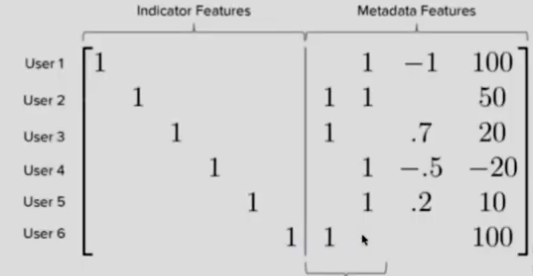

In [ ]:
def transform_features(features, id_name):
    """
    Transforms features data frame to the format build_user_features / build_item_features needs it.

    Returns iterable of (id, [list of feature names that has value]).
    """
    transformed_features = []
    for row in features.to_dict(orient="records"):
        id_value = row[id_name]
        del row[id_name]
        feature_names = {key: value for key, value in row.items() if value != 0}
        transformed_features.append(
            (id_value, feature_names)
        )
    return transformed_features

In [ ]:
transform_features(tfidf_movie, "movieId")

[(1,
  {'adventure': 0.41684567364693936,
   'animation': 0.5162254711770092,
   'children': 0.5048454681396087,
   'comedy': 0.26758647689140014,
   'fantasy': 0.482990142708577}),
 (2,
  {'adventure': 0.5123612074824268,
   'children': 0.620525172745643,
   'fantasy': 0.5936619434123594}),
 (3, {'comedy': 0.5709154064399099, 'romance': 0.8210088907493954}),
 (4,
  {'comedy': 0.5050154397005037,
   'drama': 0.46640480307738325,
   'romance': 0.726240982959826}),
 (5, {'comedy': 1.0}),
 (6,
  {'action': 0.5493281743985542,
   'crime': 0.6359470441562756,
   'thriller': 0.5420423542868653}),
 (7, {'comedy': 0.5709154064399099, 'romance': 0.8210088907493954}),
 (8, {'adventure': 0.6366993258087036, 'children': 0.7711121633813997}),
 (9, {'action': 1.0}),
 (10,
  {'action': 0.5530653284926609,
   'adventure': 0.6295217016667962,
   'thriller': 0.5457299419583338}),
 (11,
  {'comedy': 0.5050154397005037,
   'drama': 0.46640480307738325,
   'romance': 0.726240982959826}),
 (12, {'comedy': 0

In [ ]:
item_features_matrix = ds.build_item_features(transform_features(tfidf_movie, "movieId"))
item_features_matrix

<9742x9762 sparse matrix of type '<class 'numpy.float32'>'
	with 31826 stored elements in Compressed Sparse Row format>

In [ ]:
data = []
for i, row in movies_with_ratings.iterrows():
    data.append((row['userId'], row['movieId']))

data[:10]

[(1, 1),
 (5, 1),
 (7, 1),
 (15, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (21, 1),
 (27, 1),
 (31, 1)]

In [ ]:
interaction_matrix = ds.build_interactions(data=data)[0]
interaction_matrix

<610x9742 sparse matrix of type '<class 'numpy.int32'>'
	with 100836 stored elements in COOrdinate format>

In [ ]:
dist(pos1, pos2) < dist(pos1, neg)

In [ ]:
from scipy import sparse

model = LightFM(no_components=30, random_state=10, loss='bpr')
model.fit(interaction_matrix, epochs=10, item_features=item_features_matrix)

In [ ]:
n_items = interaction_matrix.shape[1]
user_id = 2
scores = model.predict(user_id, np.arange(n_items))
scores

array([-2.0344148, -2.6314387, -3.5380545, ..., -3.4019089, -3.5515428,
       -3.3523276], dtype=float32)

In [ ]:
len(scores)

9742

In [ ]:
scores = pd.Series(scores)
scores.index = movies['title']
scores.sort_values(ascending=False)

title
Forrest Gump (1994)                                      0.158636
Lord of the Rings: The Return of the King, The (2003)   -0.870440
Matrix, The (1999)                                      -0.938254
Pulp Fiction (1994)                                     -0.949107
Shawshank Redemption, The (1994)                        -0.997824
                                                           ...   
Run Lola Run (Lola rennt) (1998)                        -4.200052
Heathers (1989)                                         -4.201553
Under Siege 2: Dark Territory (1995)                    -4.225579
Sleeper (1973)                                          -4.238766
Butch Cassidy and the Sundance Kid (1969)               -4.267223
Length: 9742, dtype: float32

**Дополнительные материалы:**
1. Пример гибридной рекомендательной системы https://www.kaggle.com/code/parthplc/interview-building-recommendation-system-lightfm
2. Пример решения на RecSys Challenge https://habr.com/ru/companies/avito/articles/439206/
3. Доклад на тему LightFM https://youtu.be/GC0K27AZ_Pg?t=1089